In [1]:
%load_ext autoreload
%autoreload 2

# 1. Bài toán minh họa

![](./images/00.png)

In [40]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import corr, col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as f

from modules.my_pyspark import *
from modules.my_drawer import MyDrawer

In [3]:
spark = MyPySpark(session=True, sql=True)
drawer = MyDrawer()

# 1. Clustering K-Means

_Đọc dữ liệu `5000_points.txt`_

In [4]:
file_path = r'data/5000_points.txt'

In [5]:
data = spark.readFile(file_path)

In [6]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



_Chuẩn hóa dữ liệu_

In [7]:
data = data.select(col('_c0').alias('x'), col('_c1').alias('y'))

In [8]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



_Chuyển dữ liệu_

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
vec_assember = VectorAssembler(inputCols=data.columns, outputCol='features')
final_data = vec_assember.transform(data)

_Scale dữ liệu_

In [11]:
from pyspark.ml.feature import StandardScaler

In [12]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

In [13]:
scalerModel = scaler.fit(final_data)

In [14]:
final_data = scalerModel.transform(final_data)

In [15]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



_Xây dựng model_

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [23]:
k_list = []
wssse_list = []
evaluator = ClusteringEvaluator()

for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)
    # wssse = model.summary.trainingCost(final_data)
    predictions = model.transform(final_data)
    wssse = evaluator.evaluate(predictions)
    k_list.append(k)
    wssse_list.append(wssse)
    print(f'--> With k = {k} then sum squares errors = {wssse}')

--> With k = 2 then sum squares errors = 0.5467566327645105
--> With k = 3 then sum squares errors = 0.5588747612532677
--> With k = 4 then sum squares errors = 0.4724593213673857
--> With k = 5 then sum squares errors = 0.5446161016395571
--> With k = 6 then sum squares errors = 0.6454392599061063
--> With k = 7 then sum squares errors = 0.6798678060703472
--> With k = 8 then sum squares errors = 0.6761919668425936
--> With k = 9 then sum squares errors = 0.6310132785322159
--> With k = 10 then sum squares errors = 0.7508094469373449


In [24]:
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
def line(a: pd.Series, b: pd.Series, title=""):
        plt.plot(a, b, 'co-')
        plt.xlabel(a.name, color='b', weight='bold')
        plt.ylabel(b.name, color='b', weight='bold')
        plt.title(title, fontsize=18, color='r', weight='bold')
        
        plt.show()

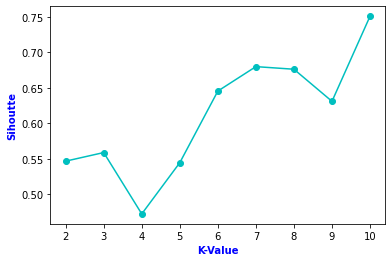

In [28]:
line(pd.Series(k_list, name='K-Value'), pd.Series(wssse_list, name='Sihoutte'))

_Xây dựng model vs K=10_

In [29]:
kmeans = KMeans(featuresCol='scaledFeatures', k=10)
model = kmeans.fit(final_data)

In [30]:
centers = model.clusterCenters()

In [31]:
centers

[array([2.50450043, 2.03880019]),
 array([3.44746743, 2.66547387]),
 array([0.68988697, 1.46808503]),
 array([1.33679274, 3.4704405 ]),
 array([3.38465688, 1.00825149]),
 array([1.380827  , 2.38362934]),
 array([2.77092183, 3.63555263]),
 array([1.63626698, 1.71503364]),
 array([1.70474147, 0.71409081]),
 array([0.57137774, 2.36652555])]

In [32]:
predictions = model.transform(final_data)

In [35]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [36]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  649|
|         6|  380|
|         3|  652|
|         5|  328|
|         9|  346|
|         4|  642|
|         8|  687|
|         7|  354|
|         2|  338|
|         0|  624|
+----------+-----+



In [37]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [38]:
temp = final_data.select('scaledFeatures').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [39]:
temp.show()

+------------------+------------------+
|                _1|                _2|
+------------------+------------------+
| 2.716775610700365| 2.336092297255214|
|2.7236722780340017|2.3658538924649704|
|2.4427660270639544| 2.440366004250274|
|2.5304142423414357|2.3382123709986073|
|2.6003217421823916|2.5782047187507375|
| 2.405652466732943|2.3642553568624516|
|2.3807614698615436| 2.315930395955543|
|2.4734656049636836|2.4362912225154716|
| 2.339913237362317|2.1977235643189017|
|2.4737069474148607| 2.436350584580287|
|2.3632252819260153| 2.491366498221345|
|2.4625642891605155|2.4369060439010557|
| 2.568734514928333|2.4364947495948375|
|2.4840642200653757|2.2767938346525014|
|2.4671947917830996| 2.437215574667591|
|2.7485182788551814|  2.42435096719268|
| 2.504169273413433| 2.418550445430756|
|2.4544609095709933|2.4393992506232864|
| 2.568505444127216| 2.518189671222758|
|2.4623761238595976| 2.562863865143543|
+------------------+------------------+
only showing top 20 rows



_Dự đoán kết quả_

In [42]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [43]:
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on='row_index').sort('row_index').drop('row_index')

In [44]:
temp.show()


+------------------+------------------+----------+
|                _1|                _2|prediction|
+------------------+------------------+----------+
| 2.716775610700365| 2.336092297255214|         0|
|2.7236722780340017|2.3658538924649704|         0|
|2.4427660270639544| 2.440366004250274|         0|
|2.5304142423414357|2.3382123709986073|         0|
|2.6003217421823916|2.5782047187507375|         0|
| 2.405652466732943|2.3642553568624516|         0|
|2.3807614698615436| 2.315930395955543|         0|
|2.4734656049636836|2.4362912225154716|         0|
| 2.339913237362317|2.1977235643189017|         0|
|2.4737069474148607| 2.436350584580287|         0|
|2.3632252819260153| 2.491366498221345|         0|
|2.4625642891605155|2.4369060439010557|         0|
| 2.568734514928333|2.4364947495948375|         0|
|2.4840642200653757|2.2767938346525014|         0|
|2.4671947917830996| 2.437215574667591|         0|
|2.7485182788551814|  2.42435096719268|         0|
| 2.504169273413433| 2.41855044

In [45]:
temp = temp.select(col('_1').alias('x_scale'), col('_2').alias('y_scale'), 'prediction')
df = temp.toPandas()

In [47]:
df = temp.toPandas()

centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1
0,2.504500,2.038800
1,3.447467,2.665474
2,0.689887,1.468085
3,1.336793,3.470441
4,3.384657,1.008251


In [49]:
import seaborn as sns

/home/manhcuong/.local/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


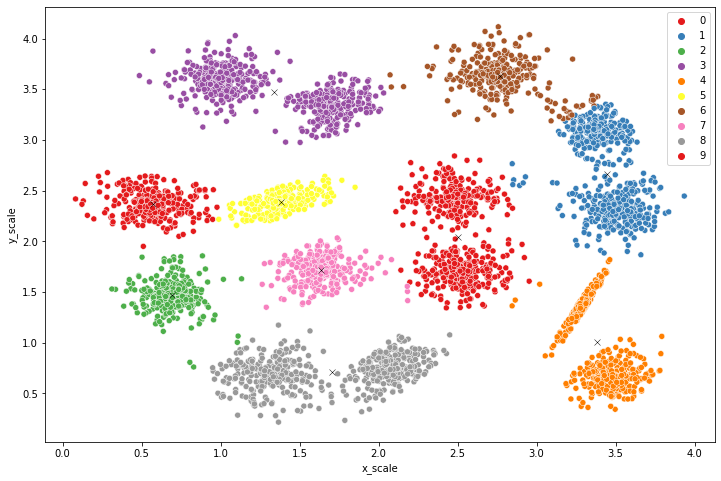

In [50]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x_scale', y='y_scale', data=df, hue='prediction', palette='Set1')
sns.scatterplot(data=centers_df, x=0, y=1, color='black', marker='x')
plt.show()